In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import TwoSlopeNorm 
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

import xgboost as xgb

import joblib

In C:\Users\Roberto\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Roberto\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Roberto\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Roberto\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Roberto\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classi

In [2]:
pd.options.display.max_rows = 100

### loading data

In [3]:
data_path = "../data"
df = pd.read_csv(data_path+ "/data_transform", index_col=0)
df = df.drop(columns=['azimuth', 'month', 'day', 'hour'])
df.sample(5)

,blind angle,fully open,ibn,idh,altitude,azimuth_sin,azimuth_cos,dgp,ill
73540,65,0,0,7,-7.719560,0.763007,0.646390,0.002978,0.425151
10832,0,0,0,158,16.097700,0.964464,-0.264214,0.107090,129.693493
33451,20,0,0,0,-16.374800,-0.996796,0.079982,0.002860,0.000000
5122,0,1,77,485,46.899500,0.868159,-0.496287,0.280802,1066.693626
4517,0,1,0,68,0.875058,0.852833,0.522184,0.220901,198.254890


### Replicating train, valid and test splits from model train notebook

In [4]:
#saving column names as list
columns = df.columns 

np.random.seed(6)

data = np.array(df)
order = list(range(len(data)))
np.random.shuffle(order)
data = data[order]
#np.random.shuffle(data)

#splitting the data into train, validation and test sets 70%, 20%, 10%
split_index = len(data)

train = data[0:int(split_index*0.7)]
val = data[int(split_index*0.7):int(split_index*0.9)]
test = data[int(split_index*0.9):]

print("train has shape: " + str(train.shape))
print("val has shape: " + str(val.shape))
print("test has shape: " + str(test.shape))

train has shape: (55188, 9)
val has shape: (15768, 9)
test has shape: (7884, 9)


### Feature normalisation

In [5]:
TRAIN_MEAN = np.load(data_path + '/means.npy')#,allow_pickle='TRUE').item()
TRAIN_STD = np.load(data_path + '/stds.npy')#,allow_pickle='TRUE').item()

NORM_COLS = ['blind angle', 'ibn', 'idh', 'altitude', 'dgp', 'ill']
COLUMN_INDICES = {name: i for i, name in enumerate(columns)}

def normalise(dataset, col_indices=COLUMN_INDICES, norm_cols=NORM_COLS,
              train_mean=TRAIN_MEAN, train_std=TRAIN_STD):
    """
    Returns normalised features with mean of zero and std of 1.
    formula is (train - train_mean) / train_std, but we index by indices
    since we dont want to normalise all columns.
    Args:
        dataset: numpy array to normalise
        col_indices -> dict: the indices of cols in dataset
        norm_cols -> list: columns to be normalised
        train_mean -> list: means of train set columns
        train_std -> list: std's of train set columns
    """
    indices = [col_indices[col] for col in norm_cols]
    dataset[:,indices] = (dataset[:,indices] - train_mean[indices]) / train_std[indices]
    return dataset

def reverse_targets(target_scaled, target_name=None):
    
    """
    Takes either a 2d array or single feature and reverses the normalisation step 
    made in the normalise function. Mean and std values are hard-coded.
    Args:
        target_scaled -> numpy array: the target variable(s) to operate on
        target_name -> bool: if operating on a single feature
    """
    
    dgp_mean = 0.03979594875697615
    dgp_std = 0.07610859804304904
    ill_mean = 82.57055868009675
    ill_std = 322.0189517267245
    
    target = target_scaled.copy()
    
    if target_name is None:
        target[:,0] =  (target[:,0] * dgp_std) + dgp_mean
        target[:,1] =  (target[:,1] * ill_std) + ill_mean
        return target
    
    else:
        if target_name == dgp:
            return (target * dgp_std) + dgp_mean
        elif target_name == ill:
            return (target * dgp_ill) + ill_mean

In [6]:
#applying normalisation to train, validation and test sets
train_norm = normalise(train.copy())
val_norm = normalise(val.copy())
test_norm = normalise(test.copy())

In [7]:
#checking normalisation worked correctly
for dataset in [train_norm, val_norm, test_norm]:
    for name, index in COLUMN_INDICES.items():
        print("%s mean: %.5f, %s std: %.2f" % (name,dataset[:,index].mean(),name,dataset[:,index].std()))
    print('\n')

blind angle mean: -0.00000, blind angle std: 1.00
fully open mean: 0.11033, fully open std: 0.31
ibn mean: 0.00000, ibn std: 1.00
idh mean: -0.00000, idh std: 1.00
altitude mean: 0.00000, altitude std: 1.00
azimuth_sin mean: 0.00206, azimuth_sin std: 0.76
azimuth_cos mean: 0.02411, azimuth_cos std: 0.66
dgp mean: 0.00000, dgp std: 1.00
ill mean: -0.00000, ill std: 1.00


blind angle mean: -0.00971, blind angle std: 1.00
fully open mean: 0.11352, fully open std: 0.32
ibn mean: 0.00260, ibn std: 1.01
idh mean: -0.00783, idh std: 0.98
altitude mean: -0.00083, altitude std: 1.00
azimuth_sin mean: 0.00475, azimuth_sin std: 0.76
azimuth_cos mean: 0.02270, azimuth_cos std: 0.65
dgp mean: 0.00269, dgp std: 1.00
ill mean: -0.00028, ill std: 0.99


blind angle mean: -0.01675, blind angle std: 1.00
fully open mean: 0.11175, fully open std: 0.32
ibn mean: -0.02100, ibn std: 0.97
idh mean: -0.00366, idh std: 0.98
altitude mean: 0.00197, altitude std: 1.00
azimuth_sin mean: -0.01060, azimuth_sin std

### XGboost

Splitting datasets into x and y's

In [8]:
train_x, train_y = train_norm[:,:-2], train_norm[:,-2:]
valid_x, valid_y = val_norm[:,:-2], val_norm[:,-2:]
test_x, test_y = test_norm[:,:-2], test_norm[:,-2:]

Defining our loss functions

In [9]:
def mae(y, yhat):
    """
    Computes Mean Absolute Error
    """
    return np.sum(np.abs(np.array(y) - np.array(yhat))) / len(np.array(y))

def ae(y, yhat):
    """
    Computes absolute error
    """
    return np.abs(np.array(y) - np.array(yhat))

Custom metrics for illuminance and glare probability accuracy

In [10]:
def accuracy_ill(y_hat, y):
    res = []
    for i in range(len(y)):
        if y[i] > 300:
            res.append(np.abs(y_hat[i] - y[i]) / y[i] < 0.2)
        elif 100 <= y[i] <= 300:
            res.append(np.abs(y_hat[i] - y[i]) / y[i] < 0.1)
        else:
            res.append(np.abs(y_hat[i] - y[i]) < 10)
    return res


def accuracy_dgp(y_hat, y):
        res = []
        for i in range(len(y)):
            if y[i] < 0.35 and y_hat[i] < 0.35:
                res.append(True)
            elif 0.35 <= y[i] < 0.4 and 0.35 <= y_hat[i] < 0.4:
                res.append(True)
            elif 0.4 <= y[i] < 0.45 and 0.4 <= y_hat[i] < 0.45:
                res.append(True)
            elif y[i] >= 0.45 and y_hat[i] >= 0.45:
                res.append(True)
            else:
                res.append(False)
        return res

Loading pre-trained models 

In [11]:
#dgp model
xg_model_dgp = joblib.load(data_path + '/xg_model_dgp')
#ill model 
xg_model_ill = joblib.load(data_path + '/xg_model_ill')

In [12]:
def return_predictions(model_dgp, model_ill, df_dgp, df_ill):
    
    #make preds
    preds_dgp = model_dgp.predict(df_dgp, ntree_limit=model_dgp.best_ntree_limit)
    preds_ill = model_ill.predict(df_ill, ntree_limit=model_ill.best_ntree_limit)
    preds_dgp = preds_dgp.reshape(len(preds_dgp), 1)
    preds_ill = preds_ill.reshape(len(preds_ill), 1)
    #join arrays
    return np.hstack((preds_dgp, preds_ill))

## Making predictions on all data with sorting reversed to show time element

In [13]:
set_labels = np.empty(len(data)).astype('O')
set_labels[0:int(split_index*0.7)] = 'Train'
set_labels[int(split_index*0.7):int(split_index*0.9)] = 'Val'
set_labels[int(split_index*0.9):] = 'Test'

data_full = np.vstack([train_norm, val_norm, test_norm])
#reversing the shuffling order
full_sorted = np.empty(data_full.shape)
labs_sorted = np.empty(len(data_full)).astype('O')
for i, j in enumerate(order):
    full_sorted[j,:] = data_full[i,:]
    labs_sorted[j] = set_labels[i]

In [14]:
x, y = full_sorted[:,:-2], full_sorted[:,-2:]

In [15]:
full_dgp = xgb.DMatrix(x, label=y[:,0].copy())
full_ill = xgb.DMatrix(x, label=y[:,1].copy())

In [16]:
#creating predictions
preds = return_predictions(xg_model_dgp, xg_model_ill, full_dgp, full_ill)
#reversing normalisation
preds_rev = reverse_targets(preds)
y_rev = reverse_targets(y)

In [17]:
# need columns for each target for absolute error, and correct or incorrect 

#correct or incorrect 
correct_dgp = accuracy_dgp(preds_rev[:,0], y_rev[:,0])
correct_ill = accuracy_ill(preds_rev[:,1], y_rev[:,1])

#absolute error ill and dgp
ae_dgp = ae(y_rev[:,0], preds_rev[:,0])
ae_ill = ae(y_rev[:,1], preds_rev[:,1])

#getting the time feature
df_hour = pd.read_csv(data_path+ "/data_transform", index_col=0)
#putting all data into a pandas dataframe so we dont get confused with column names 
input_cols = ['blind_angle', 'RC', 'ibn', 'idh', 'altitude', 'azimuth_sin', 'azimuth_cos']
results_df = pd.DataFrame(df.values[:,:-2], columns = input_cols)
results_df[['dgp_true', 'ill_true']] = y_rev
results_df[['dgp_pred', 'ill_pred']] = preds_rev
results_df['ae_dgp'] = ae_dgp
results_df['ae_ill'] = ae_ill
results_df['correct_dgp'] = correct_dgp
results_df['correct_ill'] = correct_ill
results_df['set_label'] = labs_sorted
results_df['hour'] = df_hour['hour'].values

### Error analysis with time and scatter plots

In [200]:
import seaborn as sns

def time_plot(period_from, 
              period_to,
              data_pred,
              data_true,
              correct_col,
              y_axis,
              index_false,
              scatter_x_lab,
              scatter_y_lab,
              feature,
    ):
    
    colors = ['red', 'green']
    #markers = ['^','s','D']
    #markers = ['s','^','D']
    #markers = ['D','s','^']
    markers = ['^', 'D', 's']
    
    x = np.arange(len(results_df[period_from:period_to]))
    
    fig, ax = plt.subplots(1,2, figsize=(22,10), dpi=None)
    
    legend_elements_0 = [Line2D([0], [0], marker='_', color='white', 
                              label='Correct prediction', markerfacecolor='none', markeredgecolor='green',
                              markeredgewidth = 10, markersize=20),
                         Line2D([0], [0], marker='_', color='white', 
                              label='False prediction', markerfacecolor='none', markeredgecolor='red',
                              markeredgewidth = 10, markersize=20),
                         Line2D([0], [0], marker='D', color='white', 
                              label='Focus error', markerfacecolor='red', markeredgecolor='k',markersize=10)]
    
    
    legend_elements = [Line2D([0], [0], marker='^', color='white', 
                              label='Training set prediction', markerfacecolor='White', markeredgecolor='k', markersize=10),
                       Line2D([0], [0], marker='s', color='white', 
                              label='Validation set prediction', markerfacecolor='white', markeredgecolor='k',markersize=10),
                       Line2D([0], [0], marker='D', color='white', 
                              label='Test set prediction', markerfacecolor='white', markeredgecolor='k',markersize=10),
                       Line2D([0], [0], marker='o', color='white', 
                              label='True value from RADIANCE', markerfacecolor='none', markeredgecolor='k', markersize=10),
                       Line2D([0], [0], marker='_', color='white', 
                              label='Correct prediction', markerfacecolor='none', markeredgecolor='green',
                             markeredgewidth = 10, markersize=20),
                       Line2D([0], [0], marker='_', color='white', 
                              label='False prediction', markerfacecolor='none', markeredgecolor='red',
                             markeredgewidth = 10, markersize=20)]
    
    res_false = results_df[results_df.index==index_false]
    res_rest = results_df[results_df.index!=index_false]
    
    ax[0].scatter(res_rest[res_rest['set_label']=='Test'][data_true],
                  res_rest[res_rest['set_label']=='Test'][data_pred],
                  c=[colors[c] for c in res_rest[res_rest['set_label']=='Test'][correct_col]],
                  s = 20, 
                  marker='*')
    
    #ax[0].scatter(res_false[data_true], res_false[data_pred],
    #             c='r',
    #             s=200,
    #             marker='D',
    #             edgecolor='k')
    
    sns.scatterplot(
        x=x,
        y=results_df[data_pred][period_from:period_to],
        hue=results_df[correct_col][period_from:period_to],
        palette=colors,
        style=results_df['set_label'][period_from:period_to],
        markers=markers,
        s=250,
        legend=False,
        ax=ax[1]
    )
    
    ax[1].scatter(x, 
               results_df[data_true][period_from:period_to],
               edgecolor='k', s = 500, marker='o', 
               facecolors='none')
    
    
    ax[1].plot(
        x,
        results_df[data_true][period_from:period_to]
    )
    
    ax[0].legend(handles=legend_elements_0, loc=2)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].set_ylabel(scatter_y_lab)
    ax[0].set_xlabel(scatter_x_lab)
    ax[0].grid(color='k', ls = '-.', lw = 0.2)
    #ax[0].set_xlim(0, 300)  
    #ax[0].set_ylim(0, 300)
    
    ax[1].grid(color='k', ls = '-.', lw = 0.2)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].set_ylabel(y_axis)
    ax[1].set_xlabel("Hour of day")
    ax[1].legend(handles=legend_elements)
    
    ax[1].set_xticks(list(results_df['hour'][period_from:period_to]))
    plt.savefig('double_'+feature, dpi=250)

#### Roseplot to show dist of error cases with time

In [33]:
times = np.arange(0, 24)
x = (times/24) * 2 * np.pi    
dic_ill = dict((k, 0) for k in times)
dic_dgp = dict((k, 0) for k in times)


for index, row in results_df[results_df['set_label']=='Test'].iterrows():
    if row.correct_ill == False and row.ill_true <= 300 and row.ill_pred <= 300:
        dic_ill[(row['hour'])] += 1
        
for index, row in results_df[results_df['set_label']=='Test'].iterrows():
    if row.correct_dgp == False:
        dic_dgp[(row['hour'])] += 1   

In [34]:
def roseplot(x, y, feature):
    
    ticks = ['12 AM', '1 AM', 
         '2 AM', '3 AM', 
         '4 AM', '5 AM', 
         '6 AM', '7 AM',
         '8 AM','9 AM',
         '10 AM','11 AM',
         '12 PM', '1 PM', 
         '2 PM', '3 PM', 
         '4 PM',  '5 PM', 
         '6 PM', '7 PM', 
         '8 PM', '9 PM', 
         '10 PM', '11 PM']
        
    fig = plt.figure(figsize=(7,7), dpi=None)
    ax = plt.subplot(111, projection = 'polar')
    
    BOTTOM = 0.5
    if feature == "DGP":
        BOTTOM = 0.0
    ax.bar(x, y, width = 0.26, edgecolor='k', bottom=BOTTOM)
    
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi/2)
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    #ax.yaxis.set_major_locator(MultipleLocator(2))
    ax.set_xticklabels(ticks)

    if feature == "DGP":
        ax.yaxis.set_major_locator(MultipleLocator(1))
    #plt.setp(ax.get_yticklabels(), visible=False)
    #plt.show()
    plt.savefig('rose_'+feature, dpi=300)

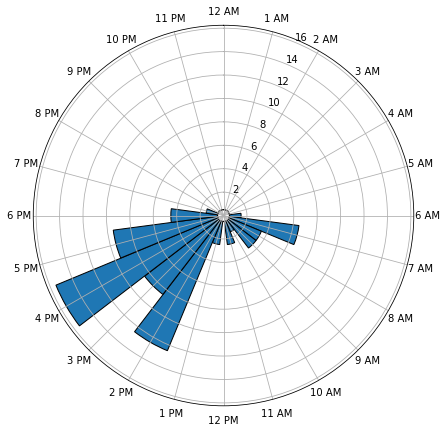

In [35]:
roseplot(x, dic_ill.values(), "WPI")

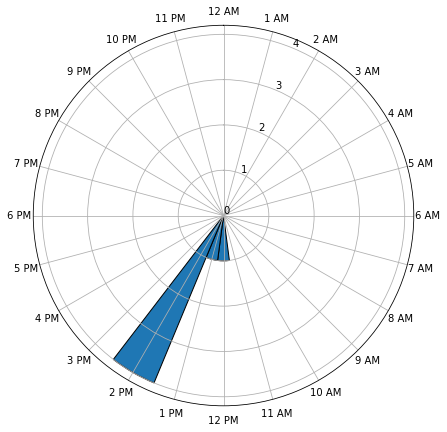

In [177]:
roseplot(x, dic_dgp.values(), "DGP")

#### Showing percentage of predictions that are above or below true values WPI

In [23]:
above_or_below=[]

for i in results_df[results_df['set_label']=='Test'].index:
    row = results_df.loc[i]
    if row['correct_ill'] == False:
        above_or_below.append(row.ill_pred - row.ill_true)

over_predict = 0
under_predict = 0
        
for i in above_or_below:
    if i >= 0:
        over_predict += 1
    else:
        under_predict += 1
        
print("Percentage of false WPI predictions over-predicted: %.3f" % (100*over_predict/len(above_or_below)))
print("Percentage of false WPI predictions under-predicted: %.3f" % (100*under_predict/len(above_or_below)))

Percentage of false WPI predictions over-predicted: 62.791
Percentage of false WPI predictions under-predicted: 37.209


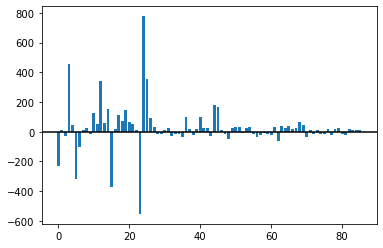

In [24]:
x = np.arange(len(above_or_below))
y = np.array(above_or_below)
plt.bar(x, above_or_below)
plt.axhline(0, c='k')

#### Time and scatter plots

In [ ]:
results_less_300 = results_df[(results_df['set_label'] == 'Test') &
                              (results_df['ill_pred'] <= 300) &
                              (results_df['ill_true'] <= 300)]

In [182]:
def ill_zoom(
    index,
):

    fig, ax = plt.subplots(1,1, figsize=(10,10), dpi=None)

    colors = ['red', 'green']

    res_false = results_less_300[results_less_300.index==index]
    res_rest = results_less_300[results_less_300.index!=index]
    
    ax.scatter(res_rest[res_rest['set_label']=='Test']['ill_true'],
                res_rest[res_rest['set_label']=='Test']['ill_pred'],
                c=[colors[c] for c in res_rest[res_rest['set_label']=='Test']['correct_ill']],
                s = 20, 
                marker='*')

    ax.scatter(res_false['ill_true'], res_false['ill_pred'],
                 c='r',
                 s=250,
                 marker='D',
                 edgecolor='k')
    ax.grid(color='k', ls = '-.', lw = 0.2)
    plt.savefig('zoom', dpi=300)

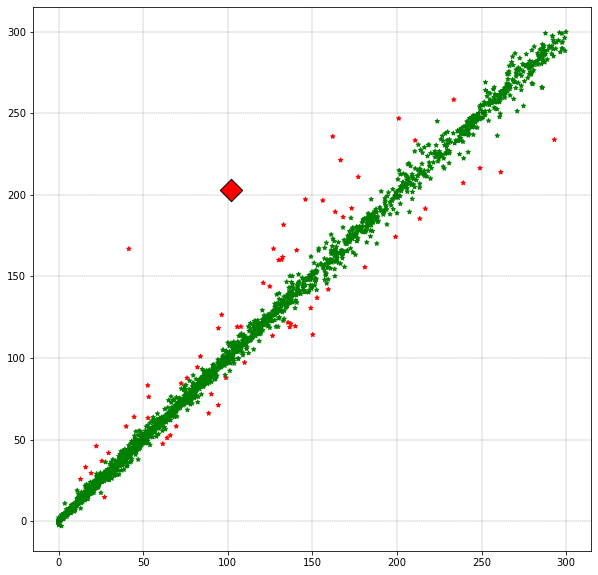

In [183]:
ill_zoom(10720)

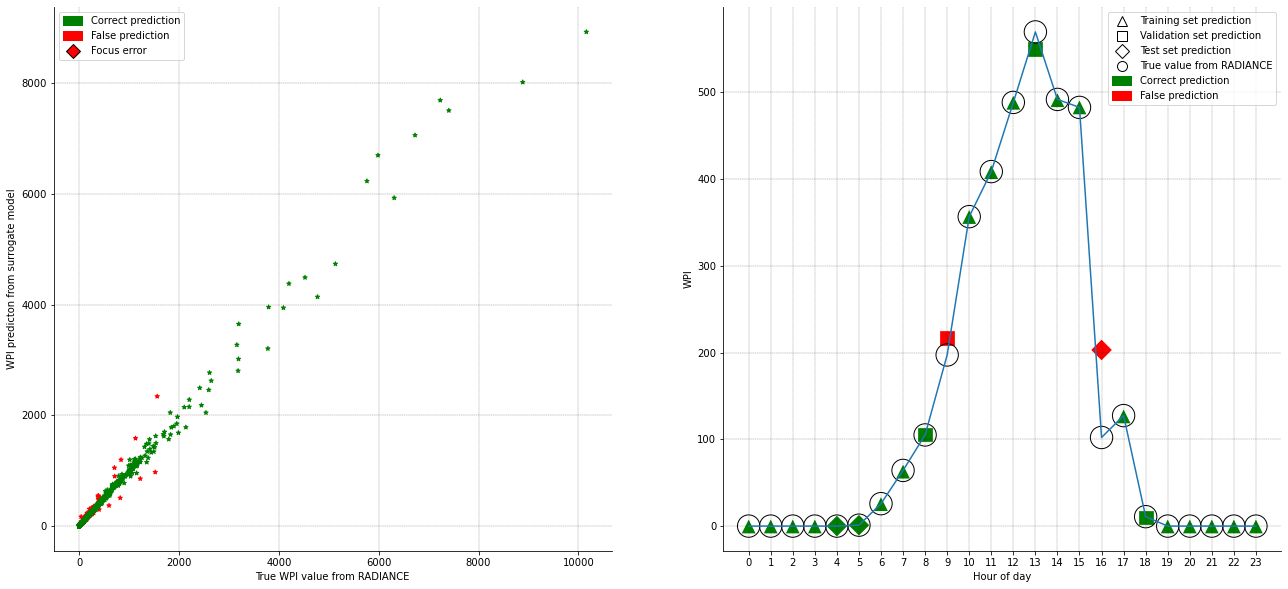

In [201]:
time_plot(
    10704,
    10728,
    'ill_pred',
    'ill_true',
    'correct_ill',
    "WPI",
    10720,
    "True WPI value from RADIANCE",
    "WPI predicton from surrogate model",
    "WPI"
)

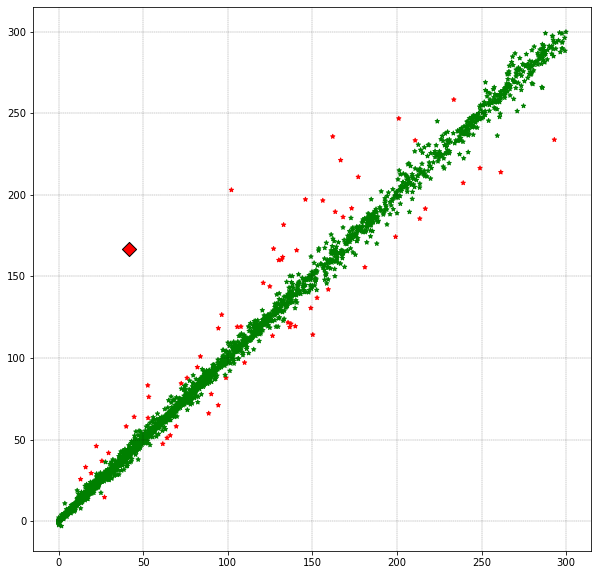

In [250]:
ill_zoom(2646)

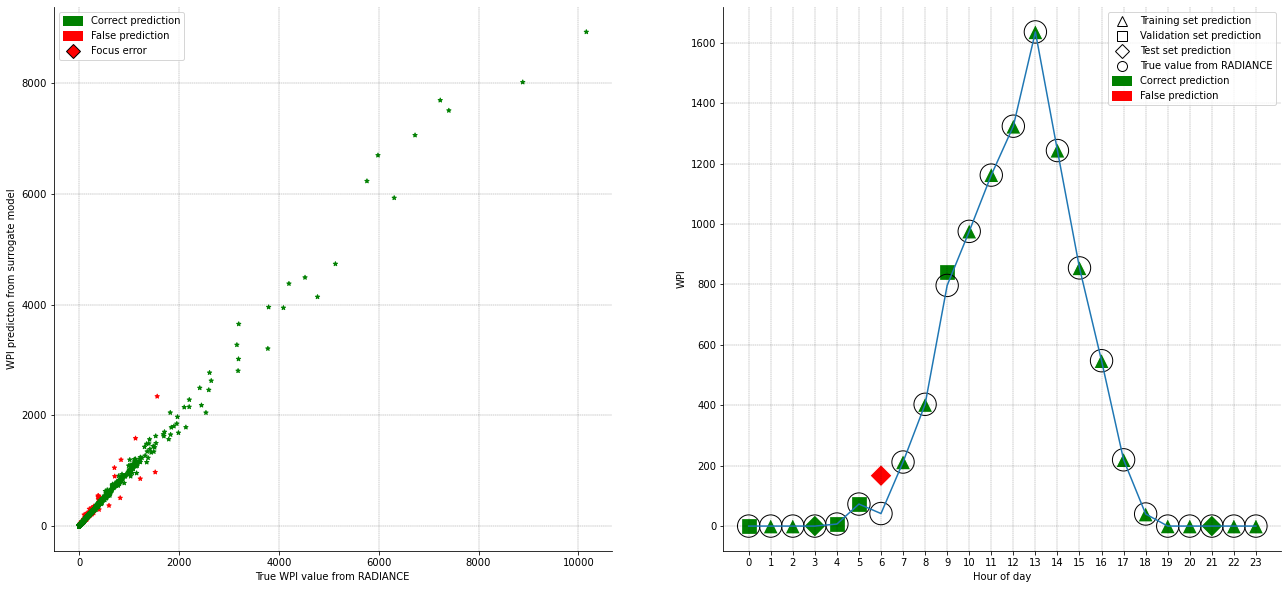

In [255]:
time_plot(
    2640,
    2664,
    'ill_pred',
    'ill_true',
    'correct_ill',
    "WPI",
    2646,
    "True WPI value from RADIANCE",
    "WPI predicton from surrogate model"
)

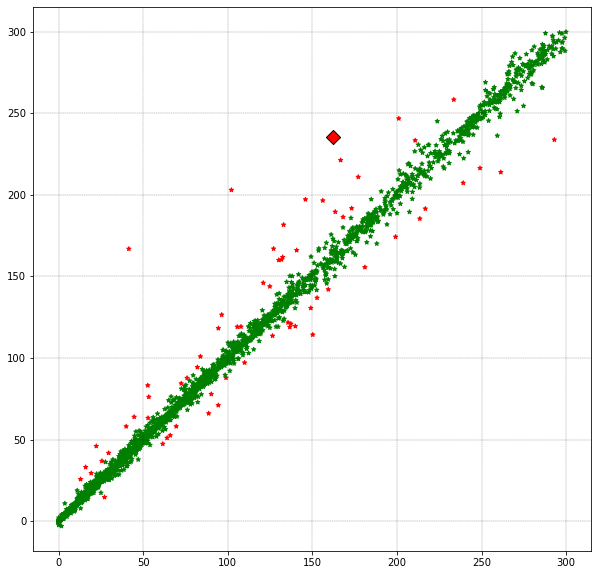

In [256]:
ill_zoom(5719)

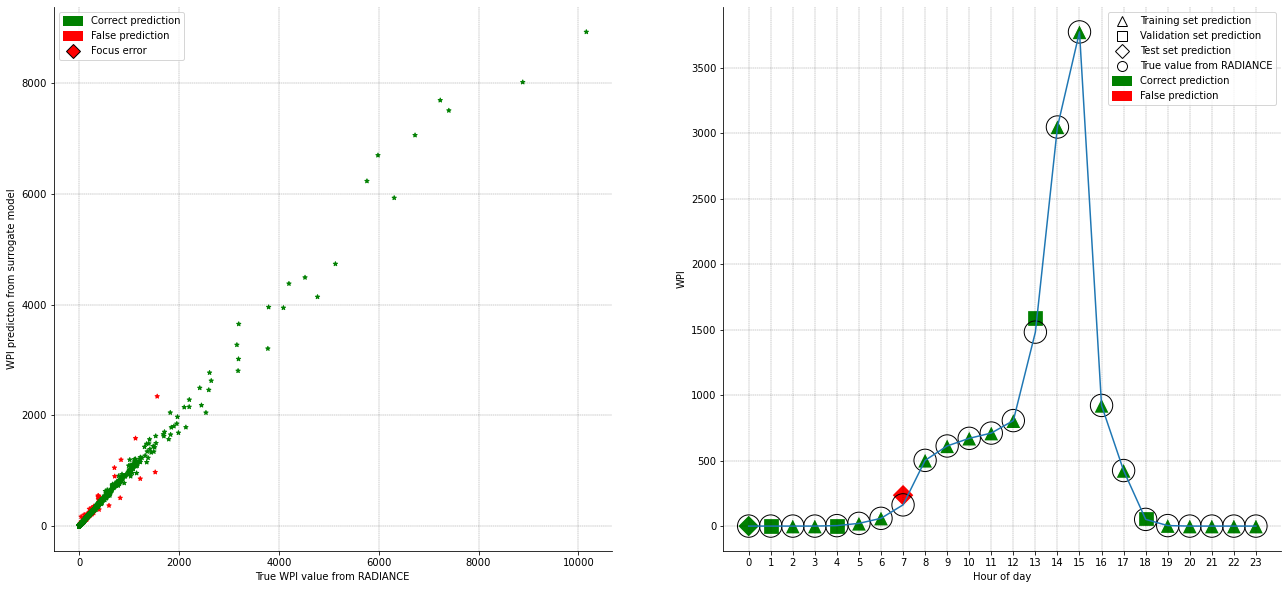

In [260]:
time_plot(
    5712,
    5736,
    'ill_pred',
    'ill_true',
    'correct_ill',
    "WPI",
    5719,
    "True WPI value from RADIANCE",
    "WPI predicton from surrogate model"
)

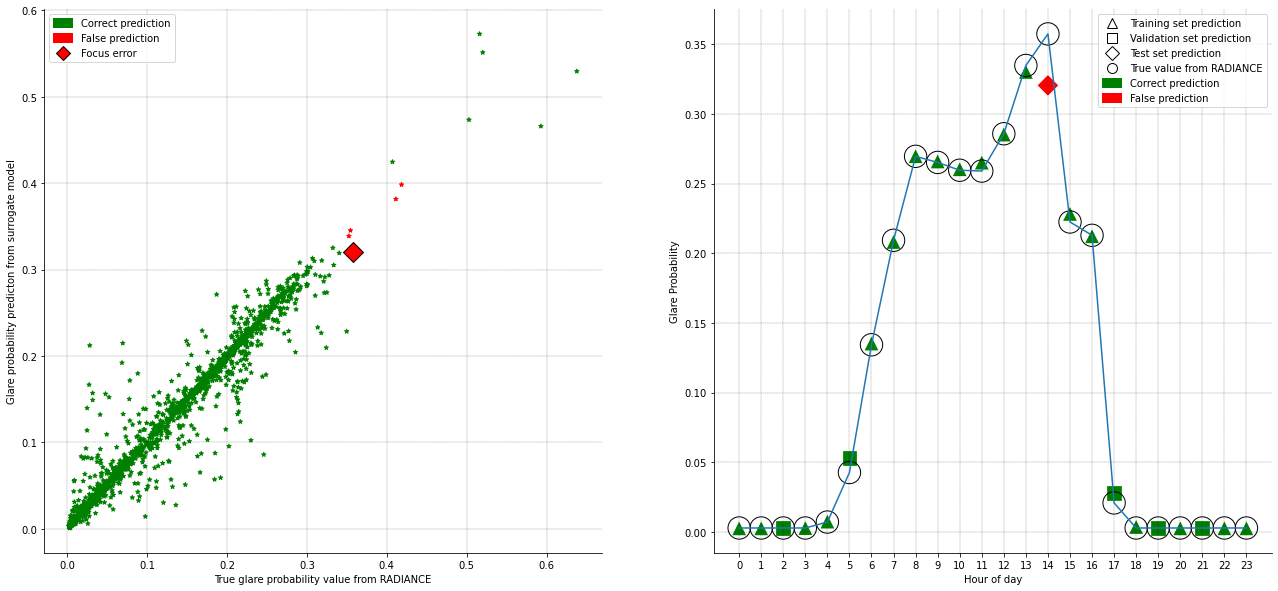

In [197]:
time_plot(
    5736,
    5760,
    'dgp_pred',
    'dgp_true',
    'correct_dgp',
    "Glare Probability",
    5750,
    "True glare probability value from RADIANCE",
    "Glare probability predicton from surrogate model",
    "DGP"
)

### Error dist plot

In [248]:
def dist_plot(errors, dpi=None):
    fig, ax = plt.subplots(figsize=(12, 6), dpi=dpi)
    ax.hist(errors, bins=80)
    plt.xlabel("Error per test set datapoint - Absolute error")
    sns.distplot(errors, rug=True, hist=False, bins=80, kde=False, label='Counts', color='blue')
    ax.axvline(np.mean(errors), ls='--', c='r', alpha=0.9, label='Mean - ' + str(round(np.mean(errors), 3)))
    plt.ylabel("No of errors per bin")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.grid(color='k', ls = '-.', lw = 0.25)
    plt.legend()
    plt.show()

/Users/oliverpaul/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/oliverpaul/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


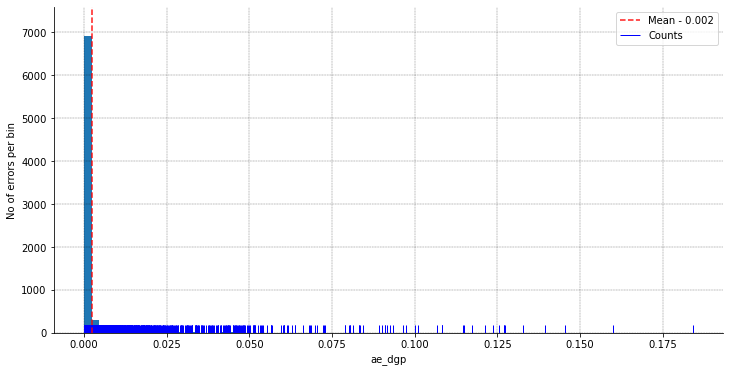

In [249]:
dist_plot(results_df[results_df['set_label']=='Test']['ae_dgp'])

/Users/oliverpaul/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/oliverpaul/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


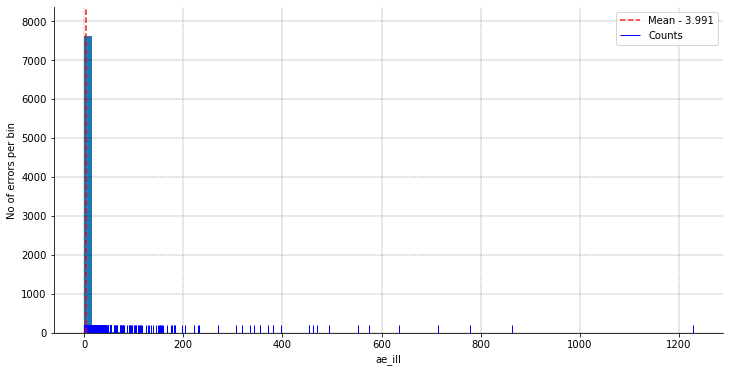

In [251]:
dist_plot(results_df[results_df['set_label']=='Test']['ae_ill'])

When looking at the distribution of errors we see there is a long tail for DGP which increases the mean error. Illuminance also has some outliers but to less of an extent... however the magnitude of these errors does seem quite large. 

### Plotting absolute error for each target against each input feature

The idea being we may be able to spot a trend for a particular feature

In [259]:
def plot_cols(column_list, error_col, correct_col, df):
    len_col = len(column_list)
    #color = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    colors = ['red', 'green']
    sizes = [200, 25]
    fig, axes = plt.subplots(len_col, figsize = (6, 6 *len_col))
    for col, ax in zip(column_list, axes): 
        ax.scatter(df[col], df[error_col], alpha = 0.3, 
                   c=[colors[c] for c in df[correct_col]],
                   s=[sizes[s] for s in df[correct_col]])
        ax.set_xlabel(col)
        ax.set_ylabel(error_col)
        ax.axhline(np.mean(df[error_col]), ls='--', c='k', alpha=0.9, label='Mean - ' + str(round(np.mean(df[error_col]), 4)))
        ax.legend()
        ax.set_title("Absolute errors against " + col)

#### Plotting absolute errors against inputs for DGP

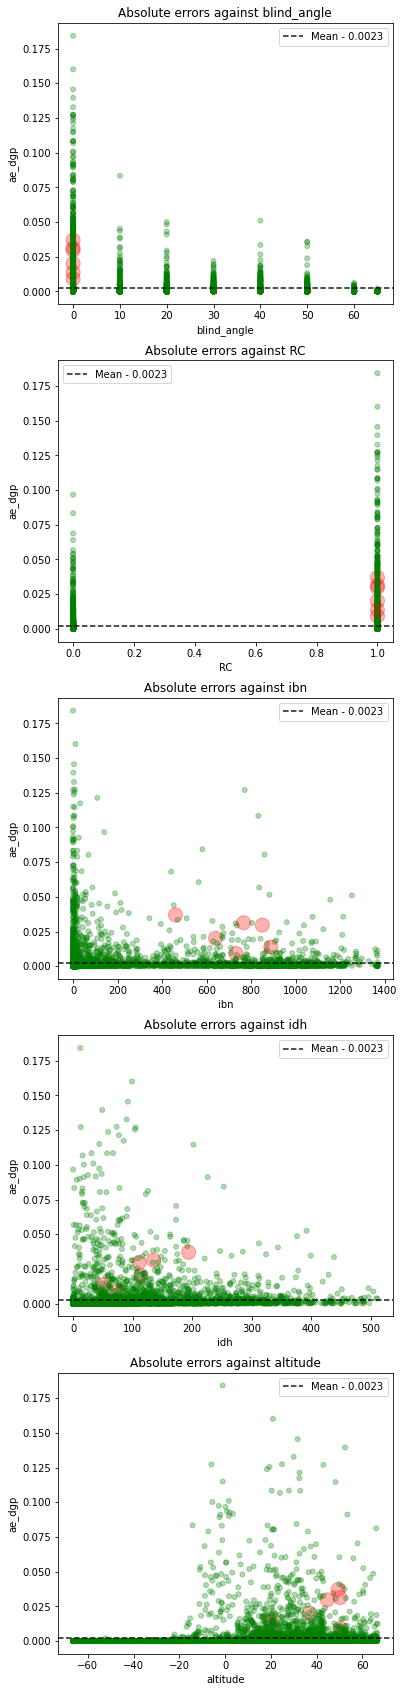

In [260]:
error_col = 'ae_dgp'
correct_col = 'correct_dgp'
cols_list = ['blind_angle', 'RC', 'ibn', 'idh', 'altitude']
plot_cols(cols_list, error_col, correct_col, results_df[results_df['set_label']=='Test'])

#### Plotting absolute errors against inputs for WPI

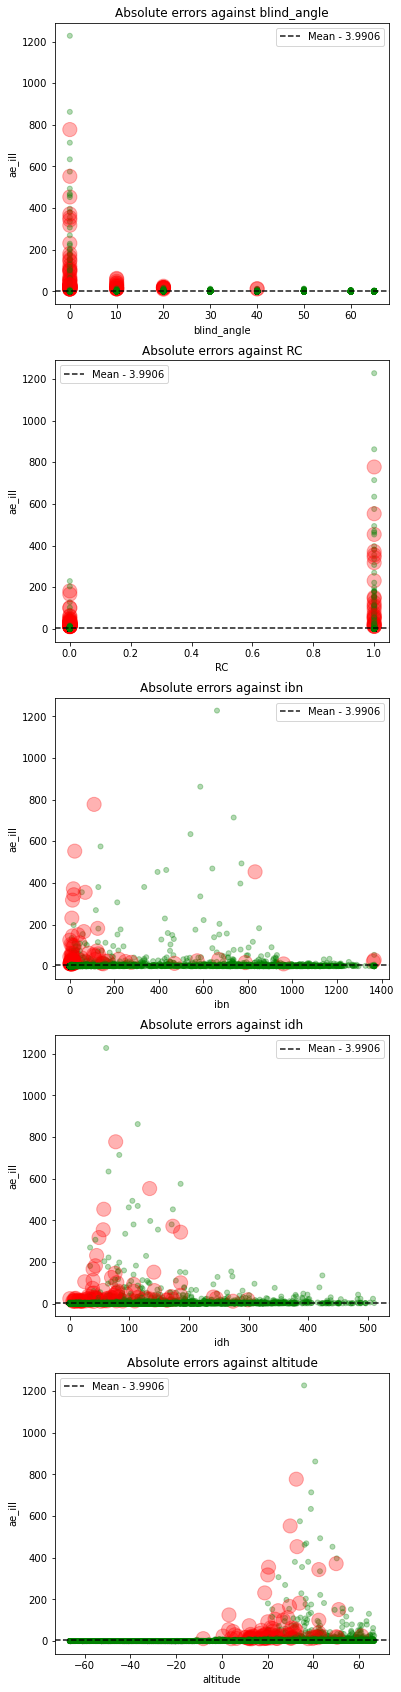

In [261]:
error_col = 'ae_ill'
correct_col = 'correct_ill'
cols_list = ['blind_angle', 'RC', 'ibn', 'idh', 'altitude']
plot_cols(cols_list, error_col, correct_col, results_df[results_df['set_label']=='Test'])

### Repeating similar analysis but presenting as correlation matrix

The idea being that in an ideal case, errors would always be zero, hence there would be zero correlation beween errors and input features. By plotting the correlation matrix we can see which features are most strongly *linearly* correlated with the model errors

In [262]:
def corr_plot(target, df):
    CORR_FEATURES = ['blind_angle', 'RC', 'ibn', 'idh', 'altitude']
    CORR_FEATURES = CORR_FEATURES + [target]

    idx = np.arange(0, len(CORR_FEATURES))
    fig, ax = plt.subplots(1, 1, figsize=(10,8))
    im = ax.imshow(df[CORR_FEATURES].corr())
    ax.set_xticks(idx)
    ax.set_yticks(idx)
    ax.set_xticklabels([x for x in df.columns if x in CORR_FEATURES], rotation='vertical')
    ax.set_yticklabels([x for x in df.columns if x in CORR_FEATURES])
    plt.colorbar(im)
    plt.show()

#### Plotting correlation matrix for DGP absolute errors vs input features

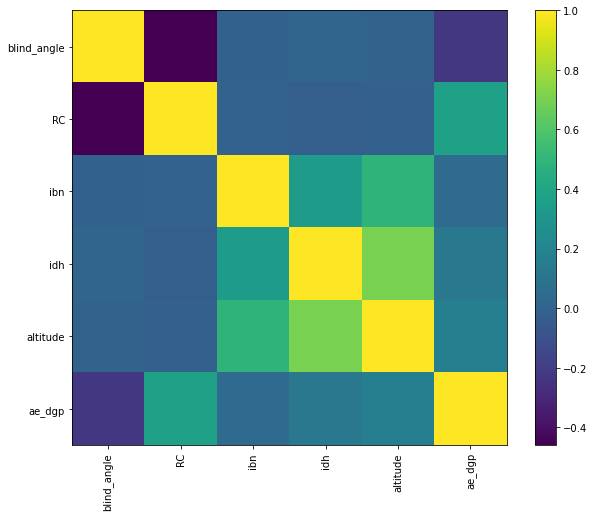

In [263]:
corr_plot('ae_dgp', results_df[results_df['set_label']=='Test'])

#### Plotting correlation matrix for DGP absolute errors vs input features

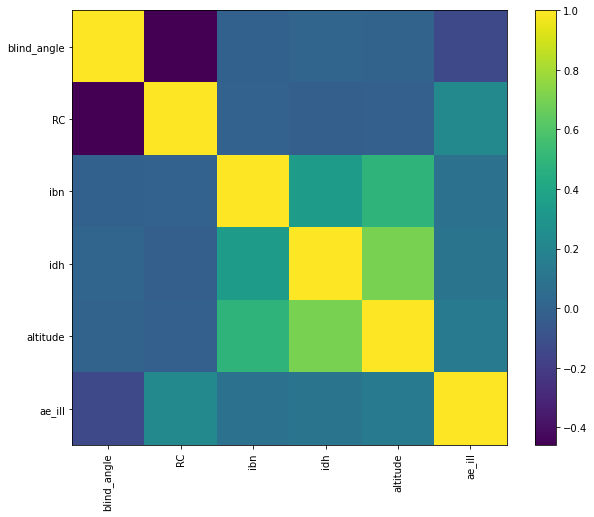

In [264]:
corr_plot('ae_ill', results_df[results_df['set_label']=='Test'])

The two above plots show the same story as the previous analysis. The errors for both DGP and WPI seem to be most effected by whether or not the simulation was an RC (reference case) ie. with no blind installed, or when the blind angle is 0 (the impact is greater for DGP). This implies that the model has learned well the relationship between blind angles and WPI and DGP, but shows strong errors when the blinds are fully open or there is no blind installed - likely since in these cases the simulated data showed very large absolute values for these configurations which are not captured in simulated data with increased blind angles. 

### Some sweet plots from Roberto

In [265]:
def boxplot(feature, rangeBins, res_df = results_df[results_df['set_label']=='Test'], dpi=None, outliers = True):
    df = res_df.copy()
    df['bins'] = pd.cut(df[feature], rangeBins)
    width = len(set(df['bins']))*2 + 2
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(width, 6), dpi=dpi)
    box_dgp = df[['ae_dgp', 'bins']].boxplot(by='bins', showfliers=outliers, grid = False, ax=ax[0])
    ax[0].title.set_text('DGP')
    ax[0].set_ylabel('Error')
    ax[0].set_xlabel(feature)
    box_dgp = df[['ae_ill', 'bins']].boxplot(by='bins', showfliers=outliers, grid = False, ax=ax[1])
    ax[1].title.set_text('Illuminance')
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel(feature)
    fig.suptitle('')
    plt.show()

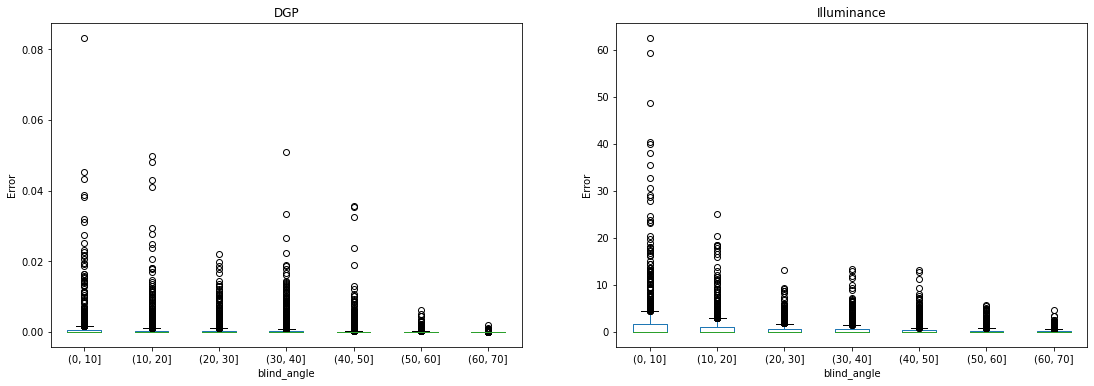

In [266]:
boxplot('blind_angle', range(0,80, 10))

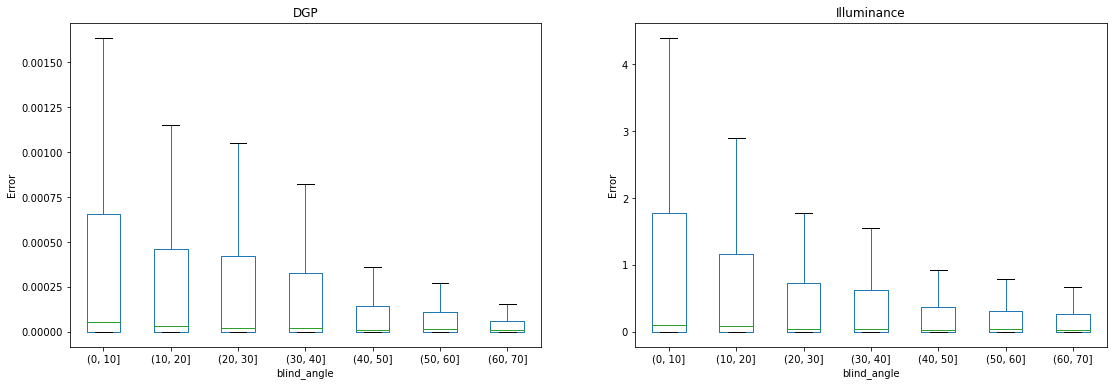

In [267]:
boxplot('blind_angle', range(0,80, 10), outliers = False)

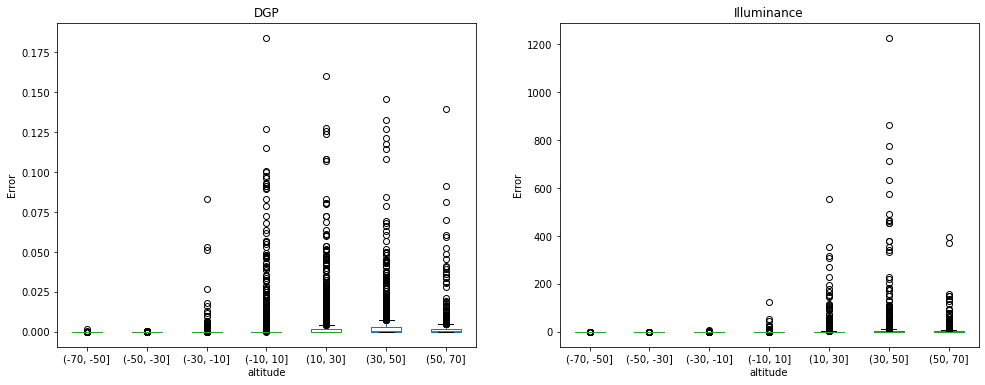

In [268]:
boxplot('altitude', range(-70,80, 20))

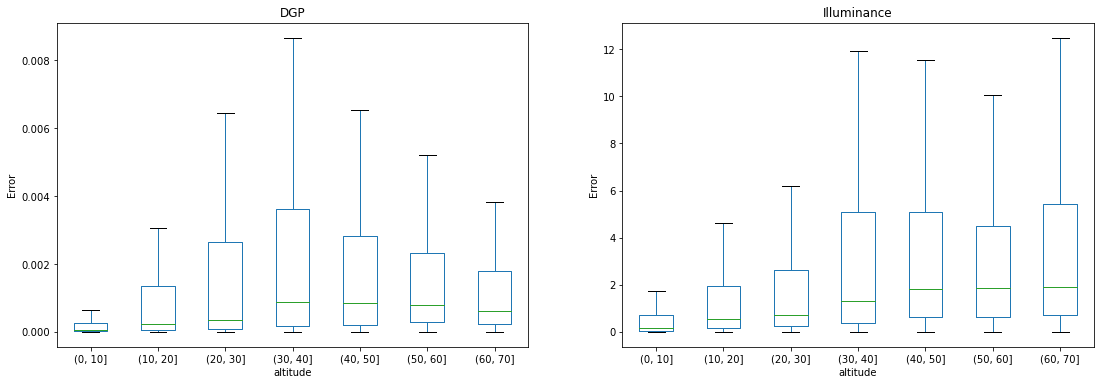

In [269]:
boxplot('altitude', range(0,80, 10), outliers = False)

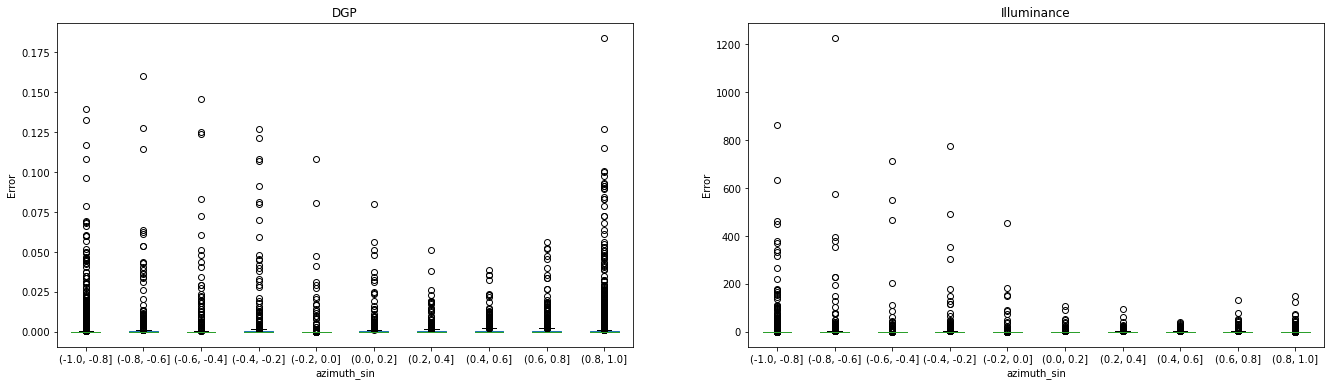

In [270]:
boxplot('azimuth_sin', np.linspace(-1, 1, 11))

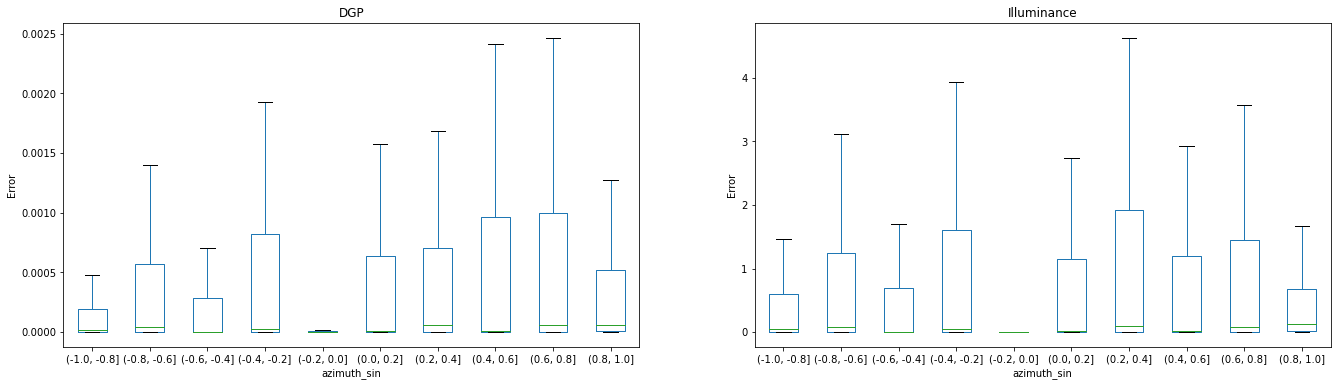

In [271]:
boxplot('azimuth_sin', np.linspace(-1, 1, 11), outliers = False)

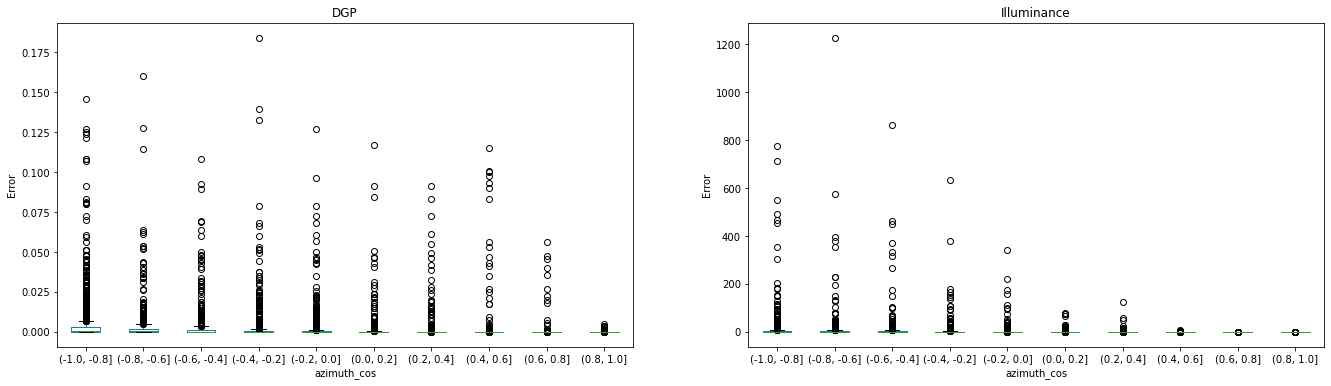

In [272]:
boxplot('azimuth_cos', np.linspace(-1, 1, 11))

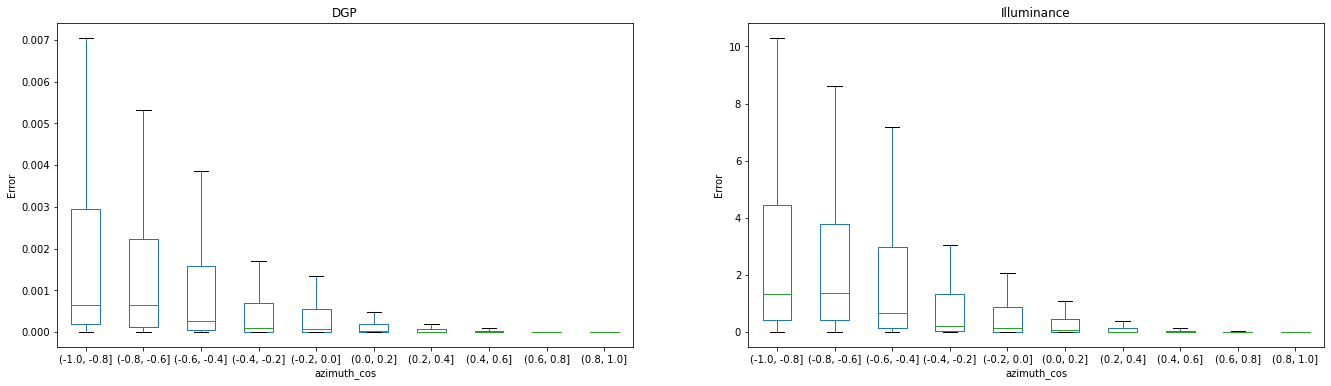

In [273]:
boxplot('azimuth_cos', np.linspace(-1, 1, 11), outliers = False)

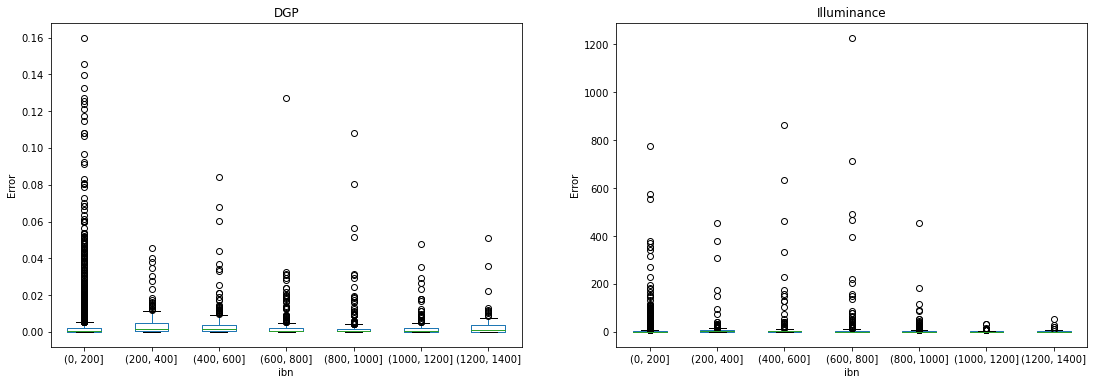

In [274]:
 boxplot('ibn', range(0,1500, 200))

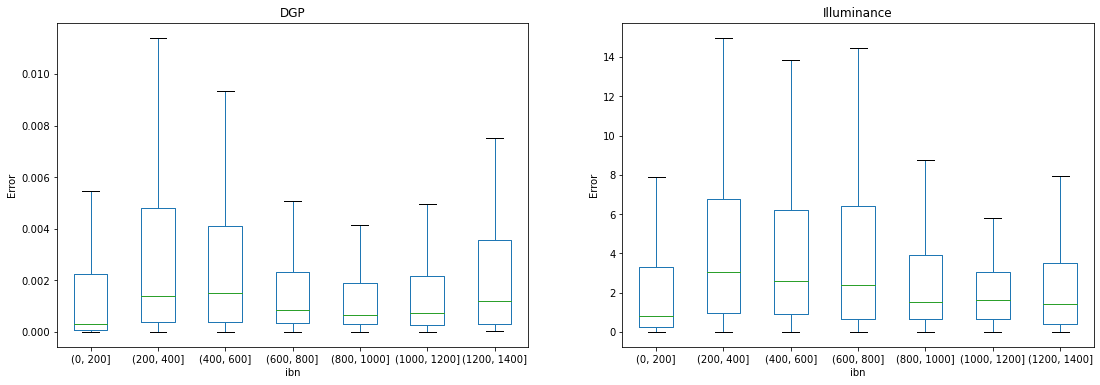

In [275]:
boxplot('ibn', range(0,1500, 200), outliers = False)

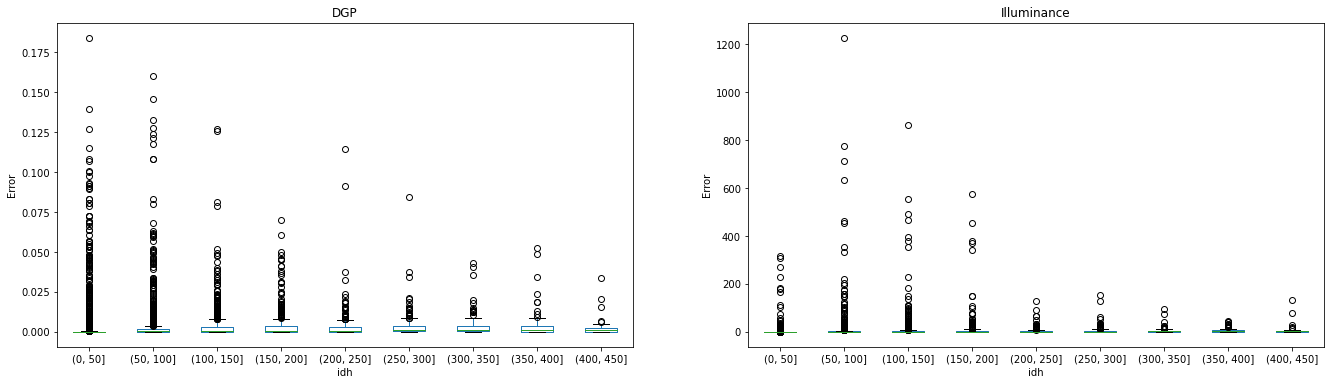

In [276]:
boxplot('idh', range(0,500, 50))

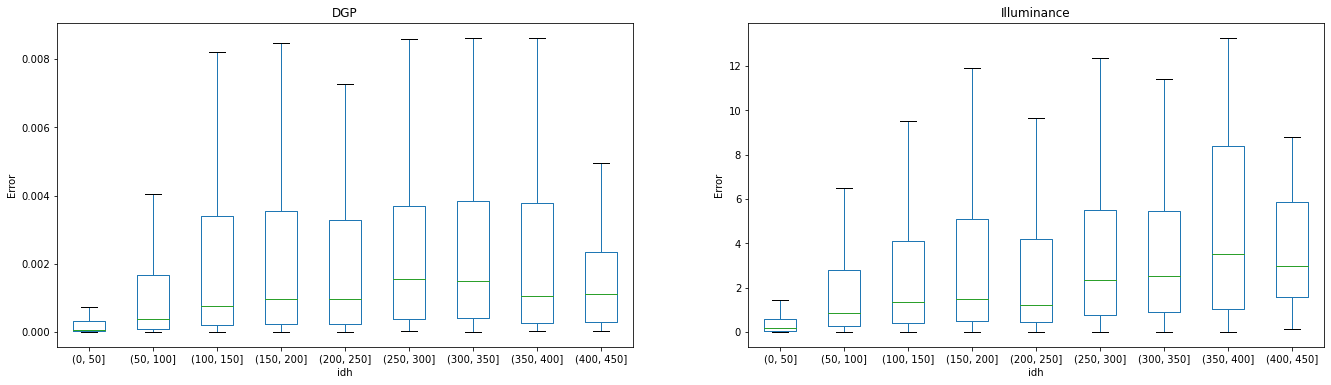

In [277]:
boxplot('idh', range(0,500, 50), outliers = False)

### More epicness from Roberto -  Plotting absolute error for each target against pairs of input features

In [278]:
def scatterPair(df, x, y, z, vcenter, palette):
    ordered_df = df.sort_values(z)
    norm = TwoSlopeNorm(vcenter = vcenter)
    fig = plt.figure(figsize=(6, 6))
    sns.scatterplot(data=ordered_df, x=x, y=y, hue=z, palette = palette, alpha = 0.7,
               hue_norm=norm)
    plt.show()

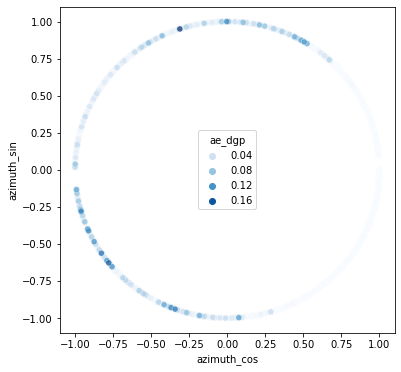

In [279]:
scatterPair(results_df[results_df['set_label']=='Test'], x="azimuth_cos", y="azimuth_sin", z="ae_dgp", vcenter = 0.1, palette = 'Blues' )

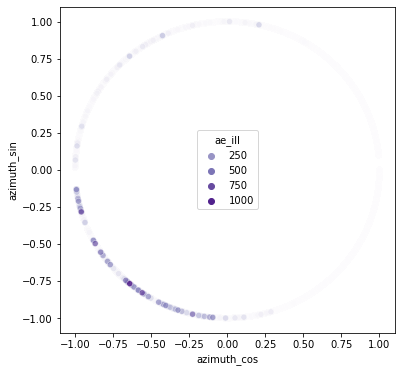

In [280]:
scatterPair(results_df[results_df['set_label']=='Test'], x="azimuth_cos", y="azimuth_sin", z="ae_ill", vcenter = 200, palette = 'Purples' )

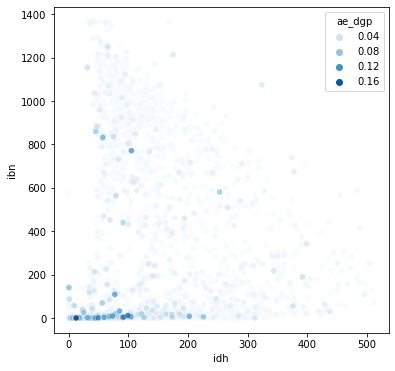

In [281]:
scatterPair(results_df[results_df['set_label']=='Test'], x="idh", y="ibn", z="ae_dgp", vcenter = 0.1, palette = 'Blues' )

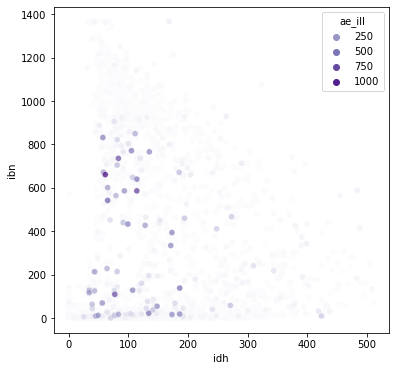

In [282]:
scatterPair(results_df[results_df['set_label']=='Test'], x="idh", y="ibn", z="ae_ill", vcenter = 200, palette = 'Purples' )

#### Bonus because they are cool

In [ ]:
#scatterPair(results_df, x="azimuth_sin", y="altitude", z="ae_dgp", vcenter = 0.01, palette = 'Paired' )

In [110]:
#scatterPair(results_df, x="azimuth_cos", y="altitude", z="ae_dgp", vcenter = 0.01, palette = 'Spectral' )

 The error is concentrated in the samples where both azimuth sin and cos are negative. This is particularly relevant for illuminance. The samples where Idh < 200 and Ibn = 0 are problematic for DGP and those where Idh < 200 and Ibn < 800 for illuminance. The 3D visualization might give a better prospective

### 3D because why not

In [283]:
def plotErrSurf(xfeat, yfeat, zfeat, df = results_df[results_df['set_label']=='Test'], elev = 20, azim = -35, 
                cmap = 'viridis', dpi = None):
    fig = plt.figure(figsize=(8, 8), dpi=dpi)
    ax = fig.gca(projection='3d')
    x = df[xfeat]
    y = df[yfeat]
    z = df[zfeat]
    ax.scatter(x, y, z, c=z, lw=0, s=20, cmap=cmap, vmin = -max(z)/2, vmax = max(z)*2)
    ax.view_init(elev=elev, azim=azim)
    # Set lables
    ax.set_xlabel('\n' + xfeat, linespacing=4, fontsize = 12)
    ax.set_ylabel('\n' + yfeat, linespacing=4, fontsize = 12)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(zfeat + '\n', linespacing=4, fontsize = 12, rotation=90)
    # Set background
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
    plt.show()

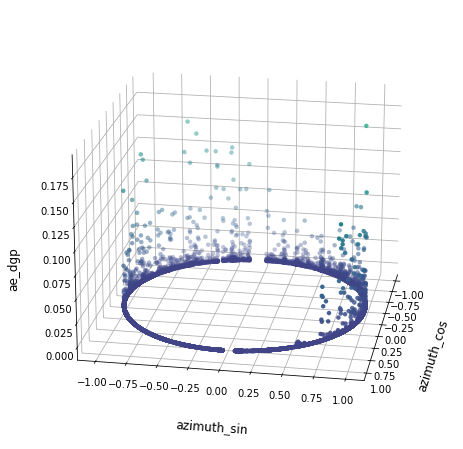

In [284]:
plotErrSurf('azimuth_cos', 'azimuth_sin', 'ae_dgp', azim = 10)

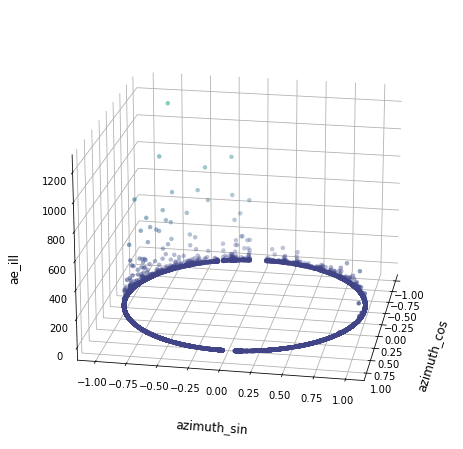

In [285]:
plotErrSurf('azimuth_cos', 'azimuth_sin', 'ae_ill', azim = 10)

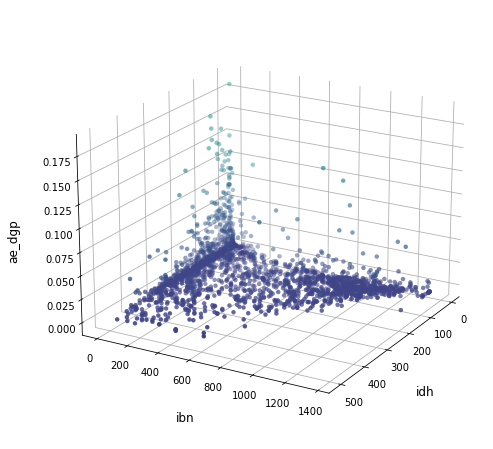

In [286]:
plotErrSurf('idh', 'ibn', 'ae_dgp', azim = 30)

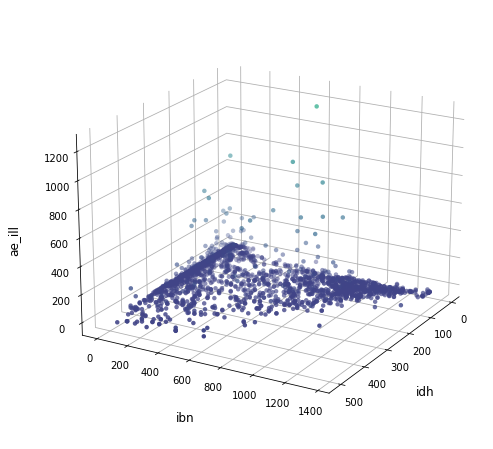

In [287]:
plotErrSurf('idh', 'ibn', 'ae_ill', azim = 30)

In [18]:
# Useless but colorful
#plotErrSurf('altitude', 'azimuth_sin', 'azimuth_cos', azim = 30, cmap = 'Paired')

Plot errror based on sun's position

In [24]:
def plotSemiErrSurf(sin, cos, alt, error, df = results_df[results_df['set_label']=='Test'], elev = 20, azim = -35,
                    cmap = 'viridis', dpi = None):
    fig = plt.figure(figsize=(8, 8), dpi=dpi)
    ax = fig.gca(projection='3d')
    r = 1
    x = r*np.sin(df[alt])*df[cos]
    y = r*np.sin(df[alt])*df[sin]
    z = r*np.cos(df[alt])
    colors = plt.cm.YlOrRd(df[error]/df[error].max())
    colors[:,-1] = df[error]/df[error].max()
    ax.scatter(x, y, z, c=colors, lw=0, s=20, cmap=cmap, vmin = -max(z)/2, vmax = max(z)*2, alpha = 0.7)
    ax.view_init(elev=elev, azim=azim)
    # Set lables
    ax.set_xlabel('\n' + sin, linespacing=4, fontsize = 12)
    ax.set_ylabel('\n' + cos, linespacing=4, fontsize = 12)
    ax.zaxis.set_rotate_label(False)
    ax.set_zlabel(alt, linespacing=4, fontsize = 12, rotation=90)
    # Set background
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
    plt.show()

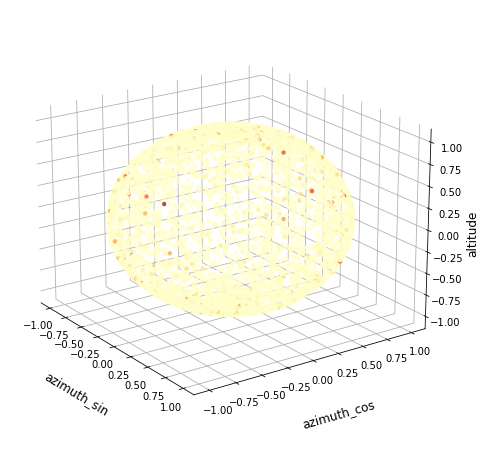

In [25]:
plotSemiErrSurf('azimuth_sin', 'azimuth_cos', 'altitude', 'ae_dgp')

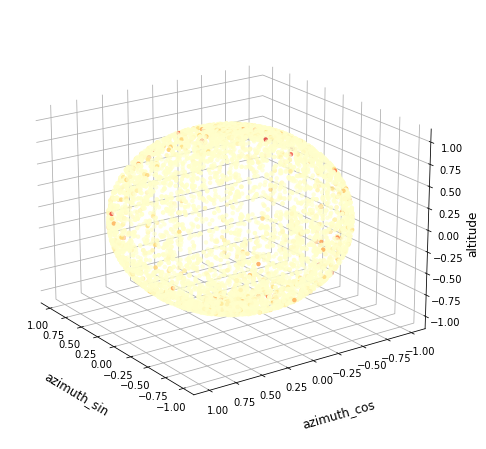

In [26]:
plotSemiErrSurf('azimuth_sin', 'azimuth_cos', 'altitude', 'ae_dgp', azim = 145)

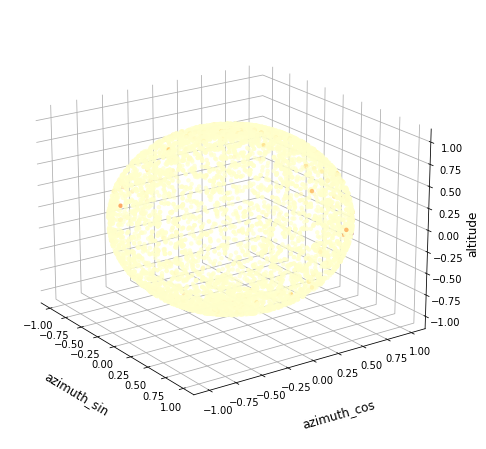

In [27]:
plotSemiErrSurf('azimuth_sin', 'azimuth_cos', 'altitude', 'ae_ill')

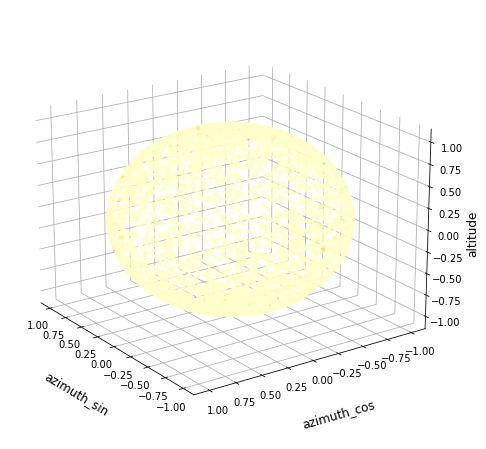

In [28]:
plotSemiErrSurf('azimuth_sin', 'azimuth_cos', 'altitude', 'ae_ill', azim = 145)

####  Plotting absolute errors against each other

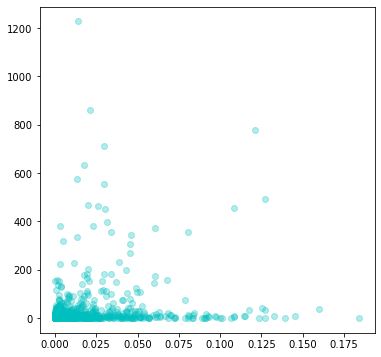

In [289]:
fig = plt.figure(figsize=(6, 6))
plt.scatter(results_df[results_df['set_label']=='Test']['ae_dgp'], results_df[results_df['set_label']=='Test']['ae_ill'], alpha = 0.3, c = 'c')
plt.show()

 Seems like it's very uncommon to have situation in which both errors are high, rather, higher errors on DGP happens when there's a low error on illuminance and vice-versa